In [1]:
# imports

# data
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# modeling and metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from pyearth import Earth
from pygam import LinearGAM, GAM, f, s, te

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# read the cleaned data into a DataFrame and check the first couple of observations
df = pd.read_csv('kc_house_data_clean.csv', index_col=0)
df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,1.0,0.0,3,...,98178,47.5112,-122.257,1340,5650,1,0,0,0,0
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,98125,47.7210,-122.319,1690,7639,0,0,2,0,1


In [10]:
# display all of the columns
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'waterfront_null', 'waterfront_ind',
       'yr_renovated_scheme1', 'yr_renovated_null', 'yr_renovated_ind'],
      dtype='object')

In [12]:
# select the columns to use in the model
used_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'waterfront_null', 'waterfront_ind',
       'yr_renovated_scheme1', 'yr_renovated_null', 'yr_renovated_ind']

In [13]:
# set variables for the model
X = df[used_cols].values
y = df['price'].values

# inspect the variables
display(X)
display(y)

array([[3.00e+00, 1.00e+00, 1.18e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 2.25e+00, 2.57e+03, ..., 2.00e+00, 0.00e+00, 1.00e+00],
       [2.00e+00, 1.00e+00, 7.70e+02, ..., 1.00e+00, 1.00e+00, 0.00e+00],
       ...,
       [2.00e+00, 7.50e-01, 1.02e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 2.50e+00, 1.60e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [2.00e+00, 7.50e-01, 1.02e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

array([221900., 538000., 180000., ..., 402101., 400000., 325000.])

In [14]:
# helper functions for use in modeling

def model_evaluate(old_pipe, bagging=True):
    if bagging:
        pipe = BaggingRegressor(old_pipe, n_estimators=3)
    else:
        pipe = old_pipe
        
    metrics = ['r2', 
               'neg_mean_absolute_error', 
               'neg_mean_squared_error']
    preds = cross_validate(pipe, X, y, 
                           cv=10, n_jobs=-1, 
                           scoring=metrics,
                           return_estimator=True, return_train_score=True)

    print("-"*60)
    for i, tag in enumerate(preds):
        if 'time' not in tag and 'estimator' not in tag:
            print(tag, ":\n\t\t\t\t\t", 
                  "%.4f" % preds[tag].mean(), 
                  "+/-", 
                  "%.4f" % preds[tag].std())
            if i % 2 == 0:
                print()
                print("-"*60)
                
    if bagging:
        coeffs = []
        for i in range(3):
            for j in range(3):
                estimator = preds['estimator'][i].estimators_[j]
                modeling_step = estimator.steps[1][0]
                coef = estimator.named_steps[modeling_step].coef_
                coeffs.append(coef)

        coeffs = [(
            "Beta_%s" % (i+1), 
            "%.4f" % np.mean(coeffs, axis=0)[i],
            "%.4f" % np.std(coeffs, axis=0)[i],
        ) for i in range(len(used_cols))]
        for coeff in coeffs:
            print(coeff[0], ":\t", coeff[1], "+/-", coeff[2])

        print()
        print("-"*60)
        
    return preds['estimator']


def model_predict(pipe):
    y_preds = [pipe[i].predict(X) for i in range(len(pipe))]
    y_pred = np.mean(y_preds, axis=0)
    return y_pred


def plot_residuals():
    SIZE = (20,8)

    plt.figure(figsize=SIZE)
    sns.scatterplot(y_pred, (y - y_pred))
    sns.lineplot(y_pred, [0]*len(y_pred), color='red')
    sns.lineplot(y_pred, [1]*len(y_pred), color='green')
    sns.lineplot(y_pred, [-1]*len(y_pred), color='green')
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.show()

    plt.figure(figsize=SIZE)
    plt.hist(y - y_pred, bins=20)
    # TODO: Add vertical lines at x=-1,0,1
    plt.show()

------------------------------------------------------------
test_r2 :
					 0.7851 +/- 0.0478
train_r2 :
					 0.8171 +/- 0.0076

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -103995.0268 +/- 6799.7846
train_neg_mean_absolute_error :
					 -101275.8764 +/- 2710.6872

------------------------------------------------------------
test_neg_mean_squared_error :
					 -28695687451.8135 +/- 5942233570.9059
train_neg_mean_squared_error :
					 -24684364109.9678 +/- 913478473.1814

------------------------------------------------------------


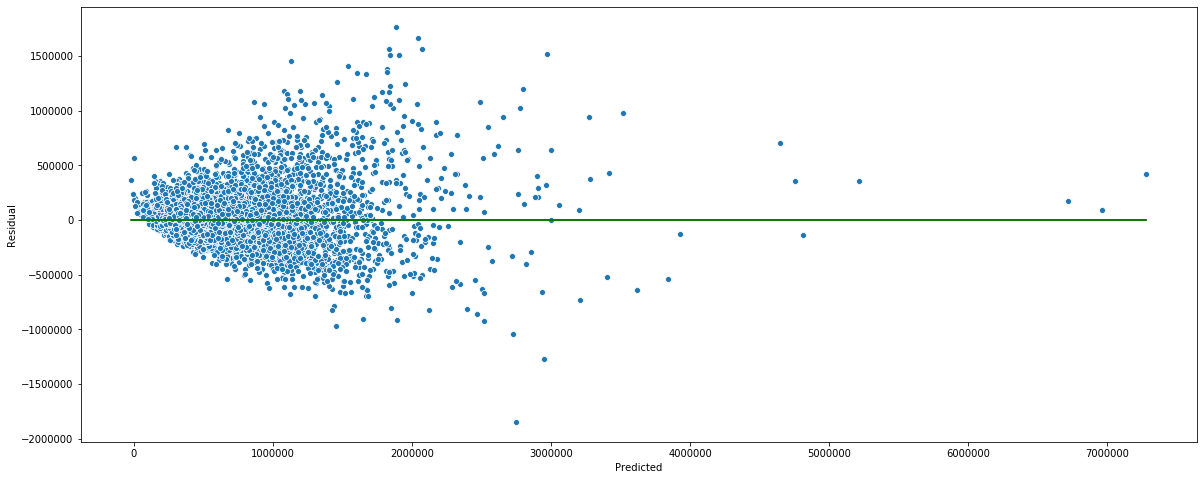

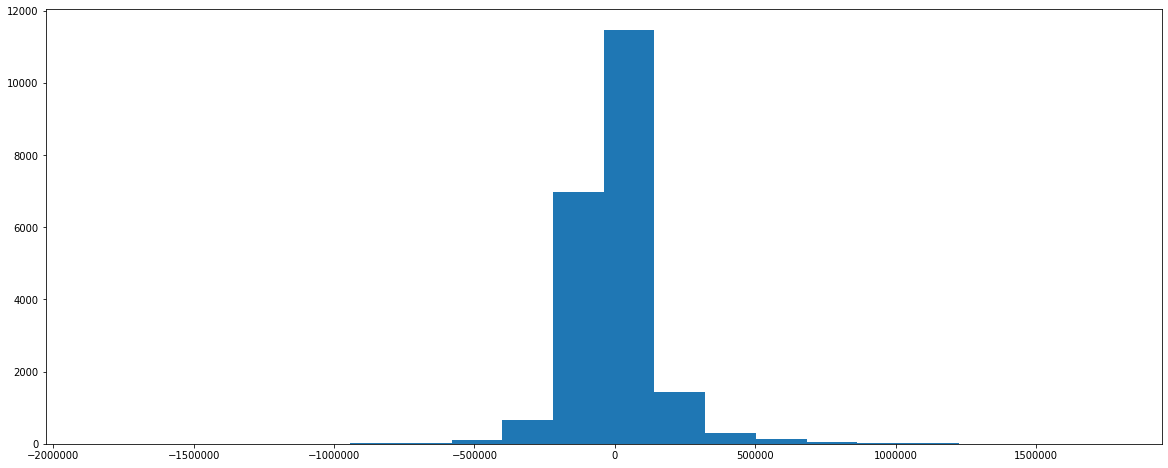

In [15]:
# this result from mars i got by removing the prices and sqft_living outliers

# run the model, make predictions using the model, and plot the residuals
scaler = RobustScaler()

criteria = ('rss','nb_subsets')

mars1 = Earth(max_degree = 2,
             feature_importance_type = criteria)
pipe1 = make_pipeline(scaler,mars1)
pipe1 = model_evaluate(pipe1,bagging=False)
y_pred = model_predict(pipe1)
plot_residuals()

In [ ]:
# Recording an earlier run to keep track of what the test and train r2 are...
#`
#         'long',                     # 0
#         'lat',                      # 1
#         'sqft_living',              # 2
#         'grade',                    # 3
#         'bathrooms',                # 4
#         'condition',                # 5
#         'waterfront',               # 6
#         'yr_renovated_scheme1',     # 7
#         'floors',                   # 8
#         'sqft_lot']].values         # 9  
        
        
# ------------------------------------------------------------
# test_r2 :
# 					 0.4642 +/- 0.8116
# train_r2 :
# 					 0.7850 +/- 0.0092

# ------------------------------------------------------------
# test_neg_mean_absolute_error :
# 					 -112189.0395 +/- 6295.0652
# train_neg_mean_absolute_error :
# 					 -108787.5648 +/- 2662.5966

# ------------------------------------------------------------
# test_neg_mean_squared_error :
# 					 -69537622403.1344 +/- 99623232426.7908
# train_neg_mean_squared_error :
# 					 -29015938127.0491 +/- 1108505115.8755

# ------------------------------------------------------------        